In [80]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [43]:
resid = pd.read_csv('../data/lr_residuals.csv', header=None)
preds = pd.read_csv('../data/lr_predictions.csv', header=None)
actual = pd.read_csv('../data/lr_actual.csv', header=None)

In [67]:
m, b = np.polyfit(preds.values.flatten(), resid.values.flatten(), 1)

In [70]:
x = preds.values.flatten()

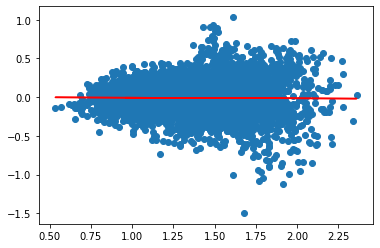

In [71]:
plt.scatter(preds, resid)
plt.plot(x, m*x + b, color = 'red')

In [10]:
r2_score(actual, preds)

0.6356362653928479

In [72]:
mean_squared_error(actual, preds)

0.05973549521113095

In [77]:
resid_2 = pd.read_csv('../data/lr_residuals_2.csv', header=None)
preds_2 = pd.read_csv('../data/lr_predictions_2.csv', header=None)
actual_2 = pd.read_csv('../data/lr_actual_2.csv', header=None)

In [78]:
mean_squared_error(actual_2, preds_2)

0.05971976282015075

In [79]:
r2_score(actual_2, preds_2)

0.6356402868139082